In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [ ]:
products = pd.read_csv('/content/counterfeit_product_dataset.csv')

In [ ]:
products

,Product_ID,Product_Name,Brand,Category,Price,Discount_Percentage,Seller_ID,Seller_Rating,Total_Sales,Return_Rate,...,Image_Similarity_Score,Logo_Recognition,Watermark_Detection,Manufacturing_Country,QR_Code_Availability,Reported_As_Fake_By_Users,Price_Anomaly,Keyword_Mismatch,Fraudulent_Seller_Flag,Is_Counterfeit
0,P0001,Ray-Ban Sunglasses,Ray-Ban,Clothing,81265,1,S0001,1.5,6142,0.45,...,0.51,Yes,No,USA,Yes,331,No,Yes,No,0
1,P0002,Adidas T-Shirt,Nike,Clothing,74538,69,S0002,3.5,9334,0.39,...,0.06,No,No,Vietnam,No,204,Yes,No,No,0
2,P0003,Rolex Watch,Adidas,Clothing,52893,16,S0003,4.1,6598,0.39,...,0.07,Yes,Yes,USA,No,364,No,No,Yes,1
3,P0004,Adidas T-Shirt,Rolex,Clothing,66581,27,S0004,3.6,3321,0.23,...,0.57,No,No,Vietnam,Yes,489,No,Yes,Yes,1
4,P0005,Adidas T-Shirt,Rolex,Clothing,29930,65,S0005,3.1,6058,0.20,...,0.57,No,No,USA,Yes,38,Yes,Yes,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,P0496,Nike Shoes,Apple,Shoes,35633,7,S0496,2.1,3728,0.06,...,0.30,No,Yes,Germany,No,224,No,No,Yes,0
496,P0497,Rolex Watch,Nike,Clothing,51177,24,S0497,2.6,7405,0.08,...,0.64,Yes,Yes,China,No,201,Yes,No,Yes,1
497,P0498,Nike Shoes,Nike,Shoes,96559,65,S0498,2.7,4412,0.00,...,0.60,Yes,Yes,USA,No,225,Yes,No,No,1
498,P0499,Nike Shoes,Ray-Ban,Electronics,95088,49,S0499,2.6,4562,0.36,...,0.70,Yes,No,USA,No,235,Yes,Yes,Yes,1


In [ ]:
products.drop(columns=['Product_ID', 'Seller_ID'], inplace=True)

In [ ]:
for col in products.select_dtypes(include=['number']).columns:
    products[col].fillna(products[col].median(), inplace=True)

for col in products.select_dtypes(include=['object']).columns:
    products[col].fillna(products[col].mode()[0], inplace=True)

In [ ]:
products.isnull().sum()

,0
Product_Name,0
Brand,0
Category,0
Price,0
Discount_Percentage,0
Seller_Rating,0
Total_Sales,0
Return_Rate,0
Seller_Verified,0
Customer_Reviews,0


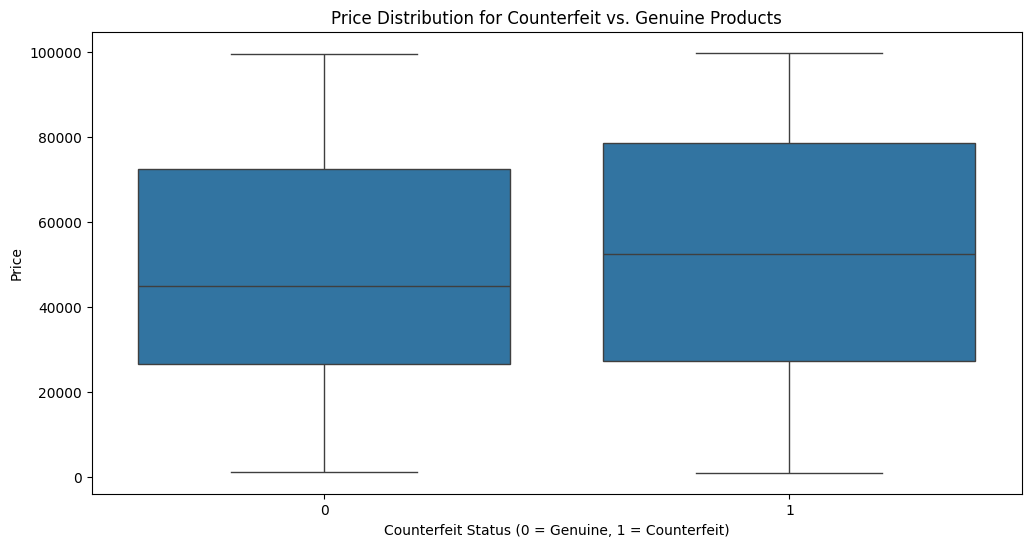

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Is_Counterfeit', y='Price', data=products)
plt.title('Price Distribution for Counterfeit vs. Genuine Products')
plt.xlabel('Counterfeit Status (0 = Genuine, 1 = Counterfeit)')
plt.ylabel('Price')
plt.show()


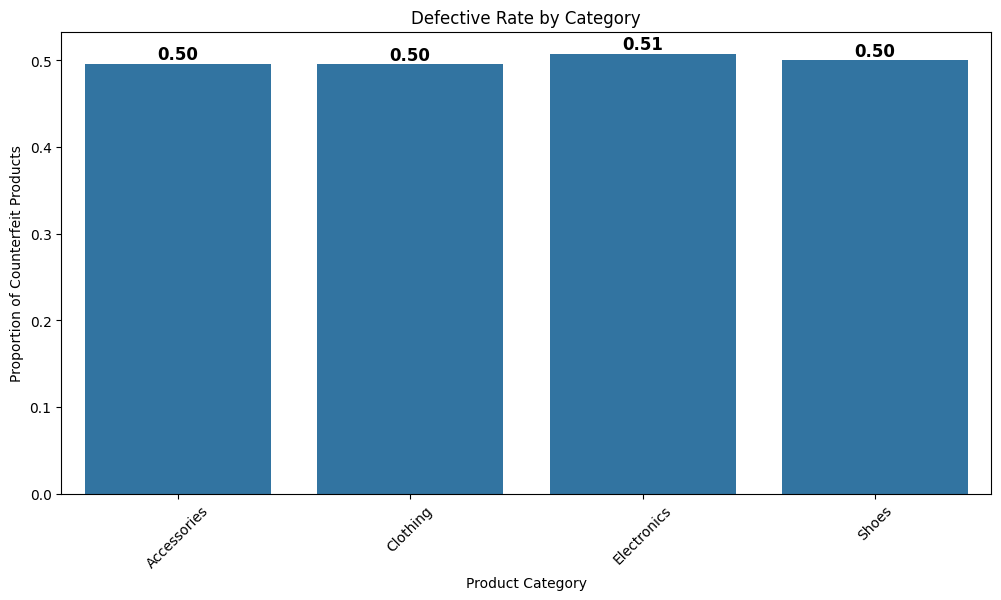

In [ ]:
plt.figure(figsize=(12, 6))

# Create the bar plot
ax = sns.barplot(
    x=products.groupby("Category")["Is_Counterfeit"].mean().index,
    y=products.groupby("Category")["Is_Counterfeit"].mean().values
)

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # Format to 2 decimal places
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Positioning
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.title("Defective Rate by Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion of Counterfeit Products")
plt.show()


In [ ]:
label_encoders = {}
for col in ['Product_Name', 'Brand', 'Category', 'Seller_Verified', 'Logo_Recognition', 'Watermark_Detection', 'Manufacturing_Country', 'QR_Code_Availability', 'Price_Anomaly', 'Keyword_Mismatch', 'Fraudulent_Seller_Flag']:
    le = LabelEncoder()
    products[col] = le.fit_transform(products[col])
    label_encoders[col] = le

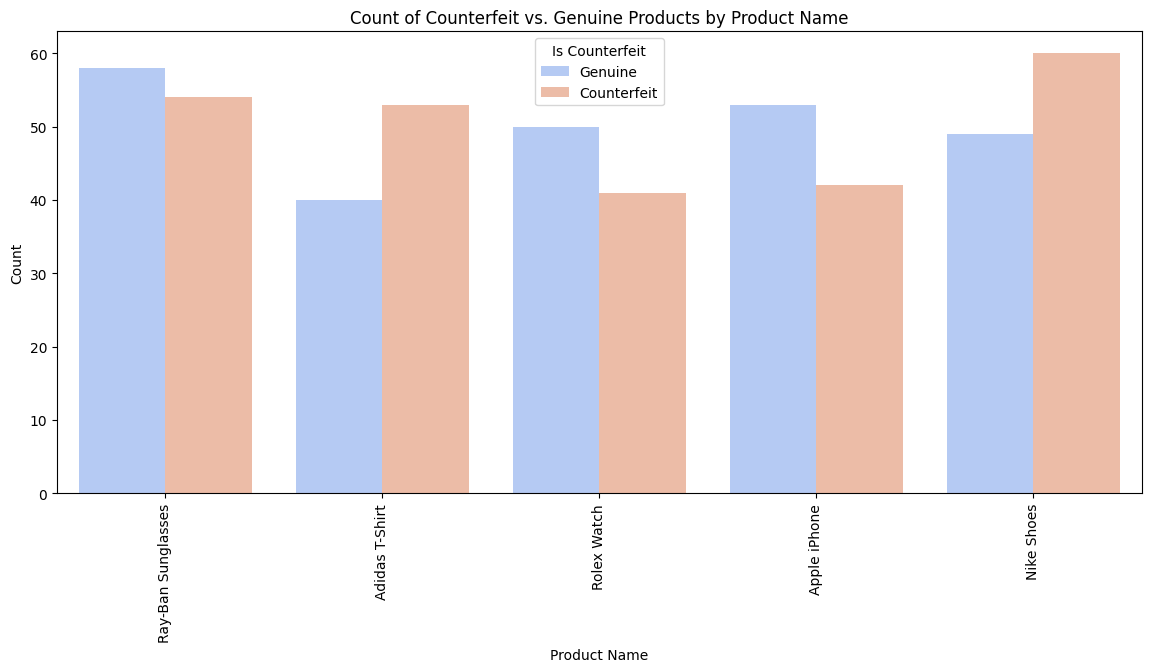

In [ ]:
product_name_mapping = {i: label_encoders['Product_Name'].classes_[i] for i in range(len(label_encoders['Product_Name'].classes_))}
products['Product_Name_Label'] = products['Product_Name'].map(product_name_mapping)

plt.figure(figsize=(14, 6))
sns.countplot(x='Product_Name_Label', hue='Is_Counterfeit', data=products, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Product Name")
plt.ylabel("Count")
plt.title("Count of Counterfeit vs. Genuine Products by Product Name")
plt.legend(title="Is Counterfeit", labels=["Genuine", "Counterfeit"])
plt.show()

In [ ]:
products['Review_Sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [ ]:
products['Sentiment_Score'] = products['Review_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
products.drop(columns=['Customer_Reviews', 'Review_Sentiment'], inplace=True)

In [ ]:
scaler = StandardScaler()
numerical_features = ['Price', 'Discount_Percentage', 'Seller_Rating', 'Total_Sales', 'Return_Rate', 'Product_Rating', 'Number_of_Reviews', 'Image_Similarity_Score', 'Reported_As_Fake_By_Users']
products[numerical_features] = scaler.fit_transform(products[numerical_features])

In [ ]:
X = products.drop(columns=['Is_Counterfeit'])
y = products['Is_Counterfeit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
products.drop(columns=['Product_Name_Label'], inplace=True, errors='ignore')

# Continue with your code as before:
X = products.drop(columns=['Is_Counterfeit'])
y = products['Is_Counterfeit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.40      0.39        47
           1       0.44      0.42      0.43        53

    accuracy                           0.41       100
   macro avg       0.41      0.41      0.41       100
weighted avg       0.41      0.41      0.41       100



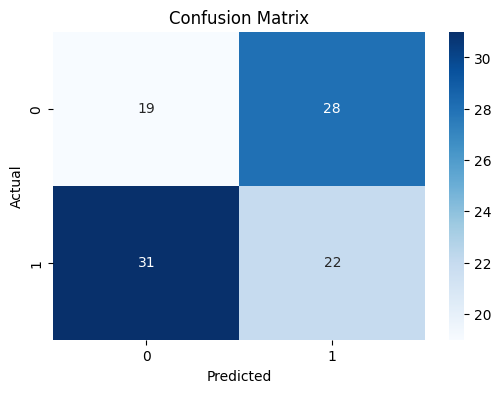

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

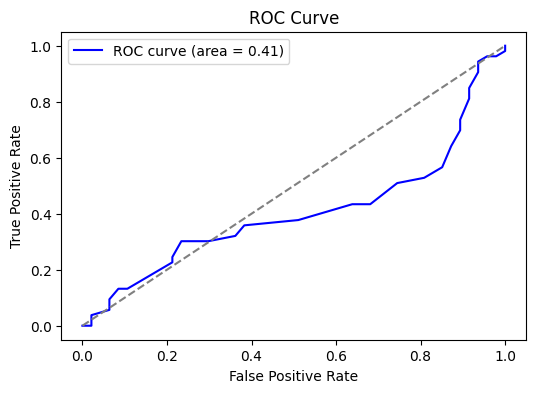

In [ ]:
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [ ]:
ensemble_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('et', extra_trees)
], voting='soft')

ensemble_clf.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 203, number of negative: 203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importanc...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgb', LGBMClassifier(random_state=42)),
                             ('et', ExtraTreesClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred2 = ensemble_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.52      0.45      0.48        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



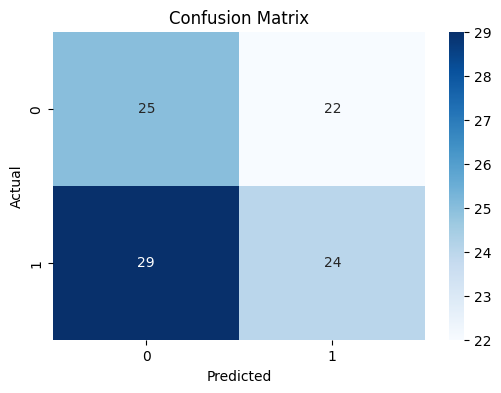

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

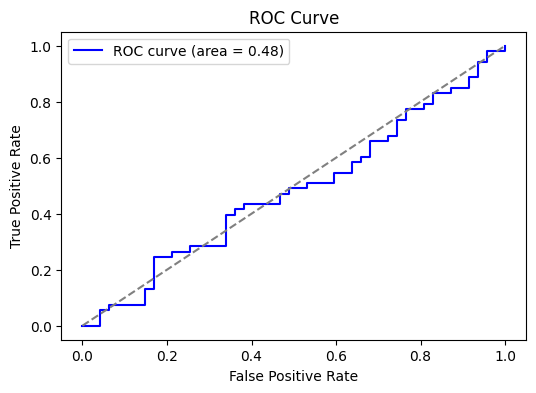

In [ ]:
fpr, tpr, _ = roc_curve(y_test, ensemble_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# 1. Count of Categories in a Tabular Form
category_counts = products.groupby('Category')['Is_Counterfeit'].value_counts().unstack().fillna(0)
category_counts.columns = ['Genuine', 'Counterfeit']
print("Category Count Table:")
print(category_counts)

Category Count Table:
          Genuine  Counterfeit
Category                      
0              67           66
1              55           54
2              62           64
3              66           66


In [ ]:
# Count of Categories in a Tabular Form
category_counts = products.groupby('Category')['Is_Counterfeit'].value_counts().unstack().fillna(0)
category_counts.columns = ['Genuine', 'Counterfeit']
category_counts.index.name = 'Category'  # Ensure the category name appears in the output

# Display the table
print("Category Count Table:")
print(category_counts)


Category Count Table:
          Genuine  Counterfeit
Category                      
0              67           66
1              55           54
2              62           64
3              66           66


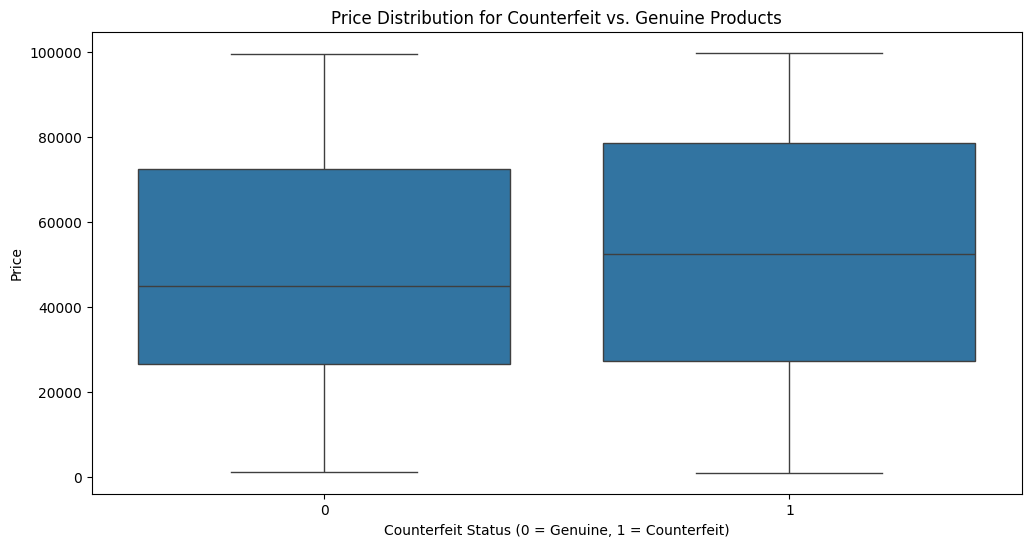

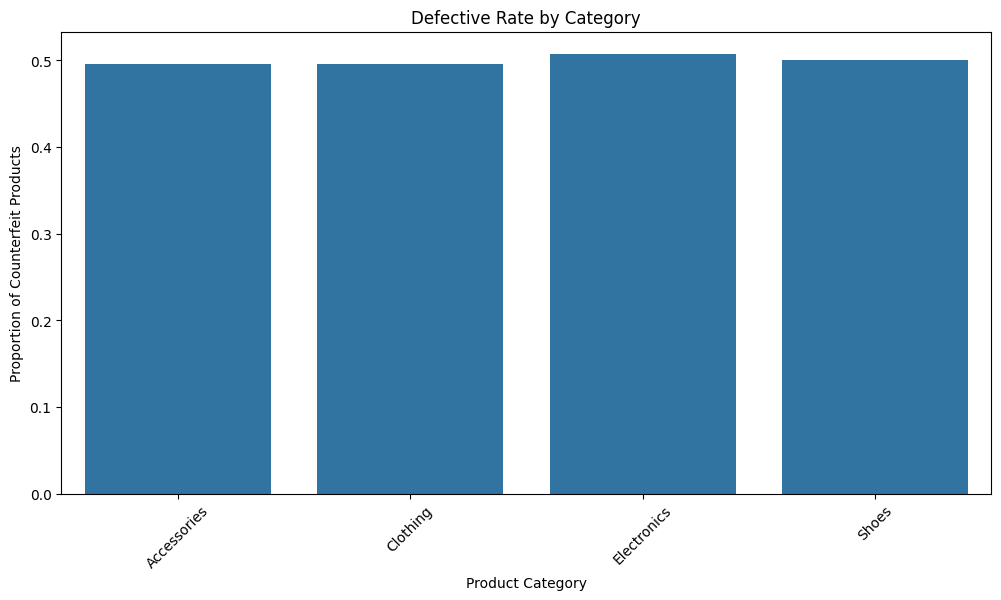

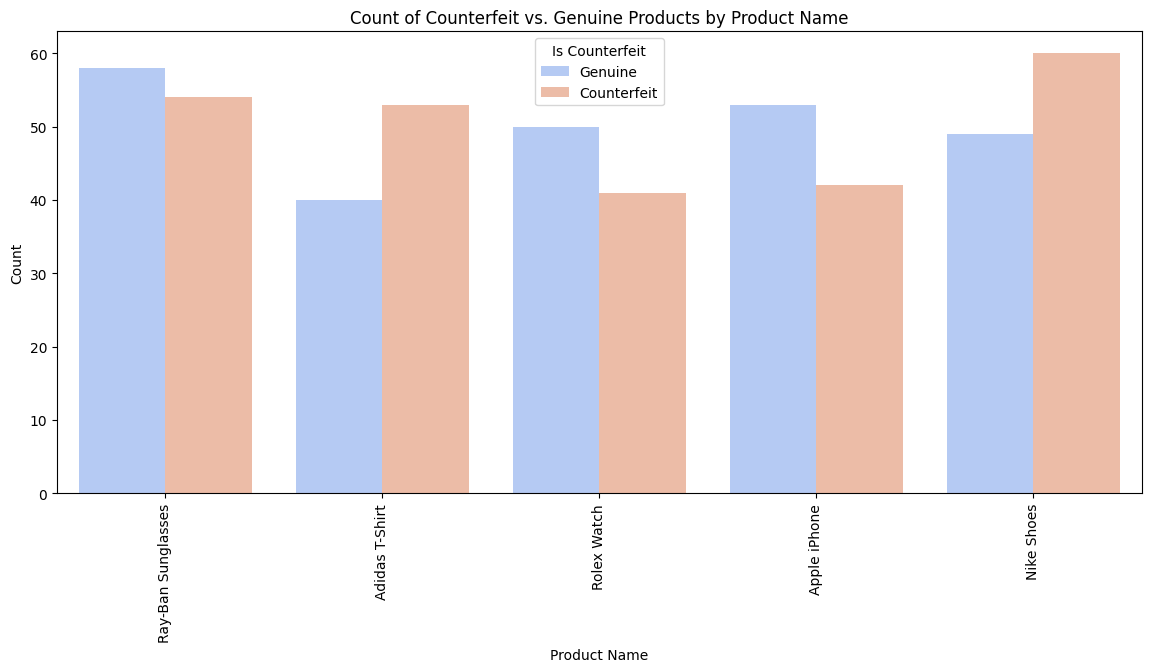

Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.48      0.43      0.46        53

    accuracy                           0.45       100
   macro avg       0.45      0.45      0.45       100
weighted avg       0.45      0.45      0.45       100



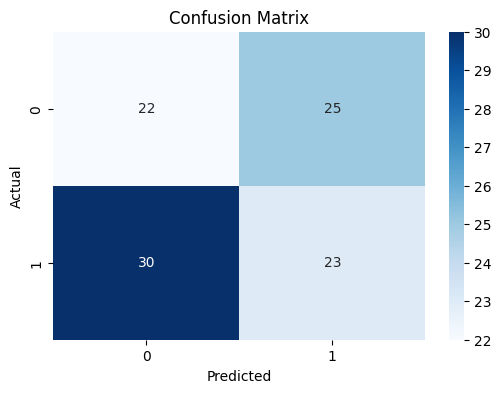

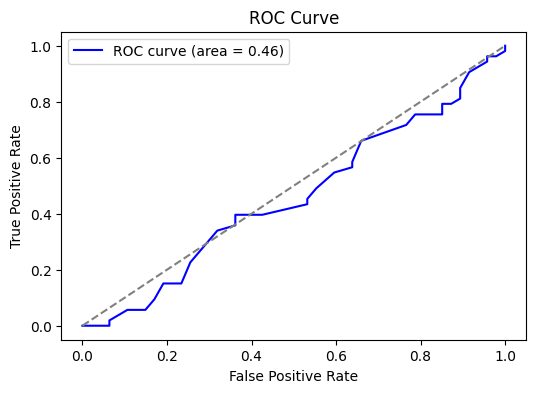

Category Count Table:
          Genuine  Counterfeit
Category                      
0              67           66
1              55           54
2              62           64
3              66           66


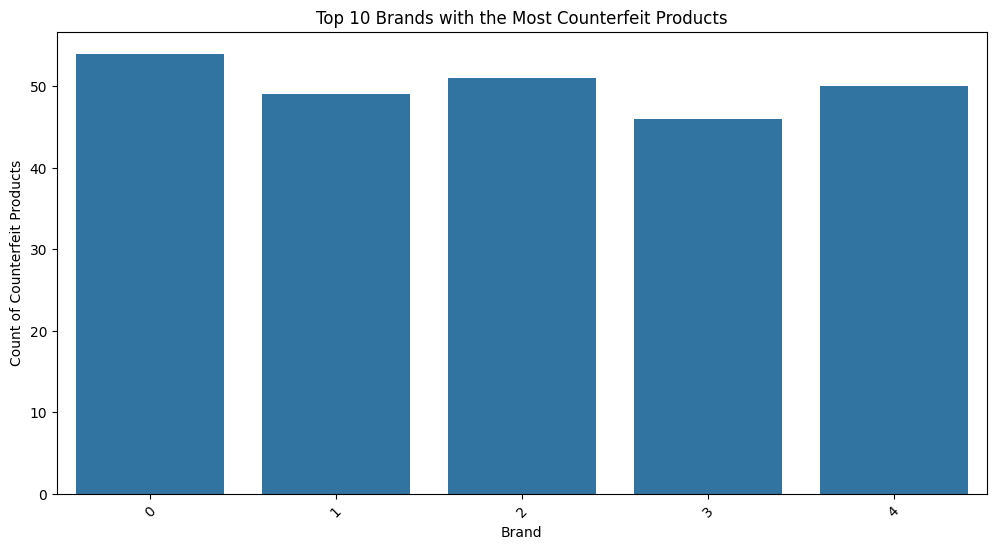

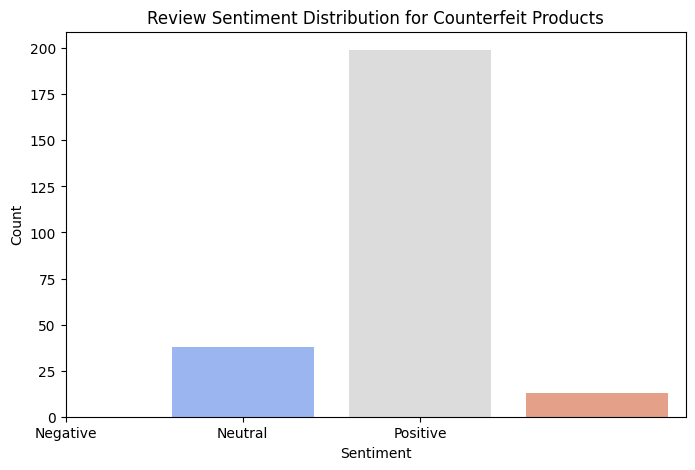

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
products = pd.read_csv('/content/counterfeit_product_dataset.csv')
products.drop(columns=['Product_ID', 'Seller_ID'], inplace=True)
for col in products.select_dtypes(include=['number']).columns:
    products[col].fillna(products[col].median(), inplace=True)

for col in products.select_dtypes(include=['object']).columns:
    products[col].fillna(products[col].mode()[0], inplace=True)
products.isnull().sum()
plt.figure(figsize=(12, 6))
sns.boxplot(x='Is_Counterfeit', y='Price', data=products)
plt.title('Price Distribution for Counterfeit vs. Genuine Products')
plt.xlabel('Counterfeit Status (0 = Genuine, 1 = Counterfeit)')
plt.ylabel('Price')
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x=products.groupby("Category")["Is_Counterfeit"].mean().index,
            y=products.groupby("Category")["Is_Counterfeit"].mean().values)
plt.xticks(rotation=45)
plt.title("Defective Rate by Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion of Counterfeit Products")
plt.show()
label_encoders = {}
for col in ['Product_Name', 'Brand', 'Category', 'Seller_Verified', 'Logo_Recognition', 'Watermark_Detection', 'Manufacturing_Country', 'QR_Code_Availability', 'Price_Anomaly', 'Keyword_Mismatch', 'Fraudulent_Seller_Flag']:
    le = LabelEncoder()
    products[col] = le.fit_transform(products[col])
    label_encoders[col] = le
product_name_mapping = {i: label_encoders['Product_Name'].classes_[i] for i in range(len(label_encoders['Product_Name'].classes_))}
products['Product_Name_Label'] = products['Product_Name'].map(product_name_mapping)

plt.figure(figsize=(14, 6))
sns.countplot(x='Product_Name_Label', hue='Is_Counterfeit', data=products, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Product Name")
plt.ylabel("Count")
plt.title("Count of Counterfeit vs. Genuine Products by Product Name")
plt.legend(title="Is Counterfeit", labels=["Genuine", "Counterfeit"])
plt.show()
products['Review_Sentiment'].unique()
products['Sentiment_Score'] = products['Review_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
products.drop(columns=['Customer_Reviews', 'Review_Sentiment'], inplace=True)
scaler = StandardScaler()
numerical_features = ['Price', 'Discount_Percentage', 'Seller_Rating', 'Total_Sales', 'Return_Rate', 'Product_Rating', 'Number_of_Reviews', 'Image_Similarity_Score', 'Reported_As_Fake_By_Users']
products[numerical_features] = scaler.fit_transform(products[numerical_features])
X = products.drop(columns=['Is_Counterfeit'])
y = products['Is_Counterfeit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
products.drop(columns=['Product_Name_Label'], inplace=True, errors='ignore')

# Continue with your code as before:
X = products.drop(columns=['Is_Counterfeit'])
y = products['Is_Counterfeit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 1. Count of Categories in a Tabular Form
category_counts = products.groupby('Category')['Is_Counterfeit'].value_counts().unstack().fillna(0)
category_counts.columns = ['Genuine', 'Counterfeit']
category_counts.index.name = 'Category'
print("Category Count Table:")
print(category_counts)

# 2. Bar Plot Showing Which Brand Has the Most Fake Products
plt.figure(figsize=(12, 6))
sns.barplot(x=products['Brand'].value_counts().index[:10], y=products[products['Is_Counterfeit'] == 1]['Brand'].value_counts().values[:10])
plt.xticks(rotation=45)
plt.title("Top 10 Brands with the Most Counterfeit Products")
plt.xlabel("Brand")
plt.ylabel("Count of Counterfeit Products")
plt.show()

# 3. Review Sentiment Distribution for Counterfeit Products
plt.figure(figsize=(8, 5))
sns.countplot(x=products[products['Is_Counterfeit'] == 1]['Sentiment_Score'], palette='coolwarm')
plt.xticks(ticks=[-1, 0, 1], labels=['Negative', 'Neutral', 'Positive'])
plt.title("Review Sentiment Distribution for Counterfeit Products")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [ ]:
# Count of Categories in a Tabular Form
category_counts = products.groupby('Category')['Is_Counterfeit'].value_counts().unstack().fillna(0)
category_counts.columns = ['Genuine', 'Counterfeit']
category_counts.index.name = 'Category'  # Ensure the category name appears in the output

# Display the table
category_counts

,Genuine,Counterfeit
Category,,
0,67,66
1,55,54
2,62,64
3,66,66


In [ ]:
# 5. Count of Brands in a Tabular Form
brand_counts = products['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

print("\nBrand Count Table:")
print(brand_counts)

# Display the table using pandas styling (if running in Jupyter Notebook)
brand_counts.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]}])



Brand Count Table:
   Brand  Count
0      0    111
1      2    101
2      4     99
3      1     95
4      3     94


,Brand,Count
0,0,111
1,2,101
2,4,99
3,1,95
4,3,94


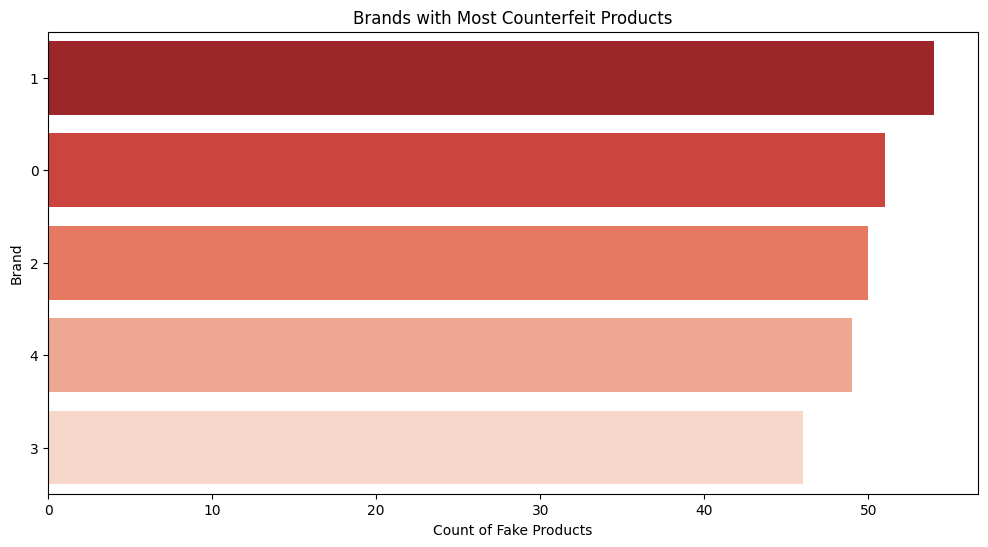

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only counterfeit products
fake_products = products[products["Is_Counterfeit"] == 1]

# Plot the count of counterfeit products per brand
plt.figure(figsize=(12, 6))
sns.countplot(y=fake_products["Brand"], order=fake_products["Brand"].value_counts().index, palette="Reds_r")
plt.xlabel("Count of Fake Products")
plt.ylabel("Brand")
plt.title("Brands with Most Counterfeit Products")
plt.show()


Brand with the Most Counterfeit Products: 1 (54 counterfeit items)


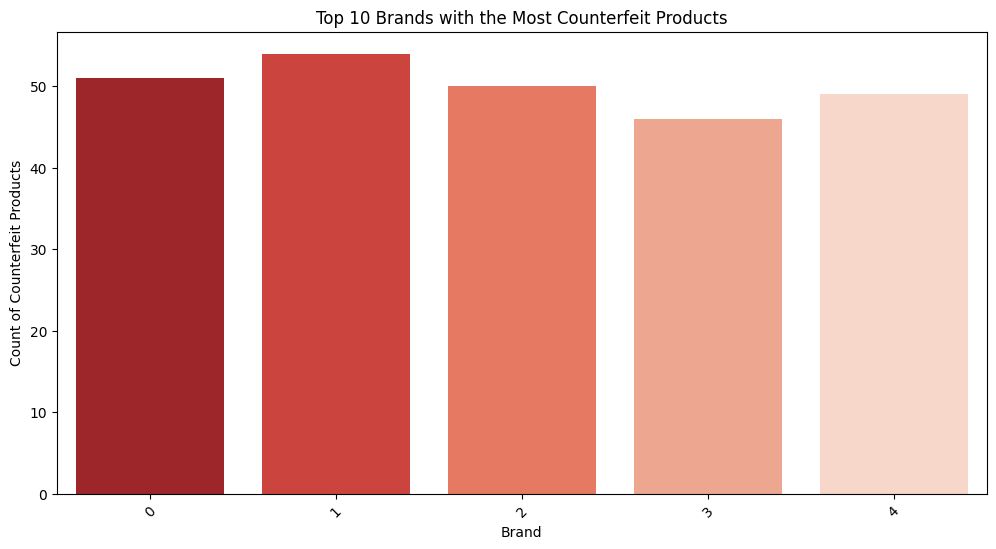

In [ ]:
# 5. Brand with the Most Counterfeit Products
counterfeit_brands = products[products['Is_Counterfeit'] == 1]['Brand'].value_counts()
top_brand = counterfeit_brands.idxmax()
top_count = counterfeit_brands.max()

print(f"\nBrand with the Most Counterfeit Products: {top_brand} ({top_count} counterfeit items)")

plt.figure(figsize=(12, 6))
sns.barplot(x=counterfeit_brands.index[:10], y=counterfeit_brands.values[:10], palette="Reds_r")
plt.xticks(rotation=45)
plt.title("Top 10 Brands with the Most Counterfeit Products")
plt.xlabel("Brand")
plt.ylabel("Count of Counterfeit Products")
plt.show()


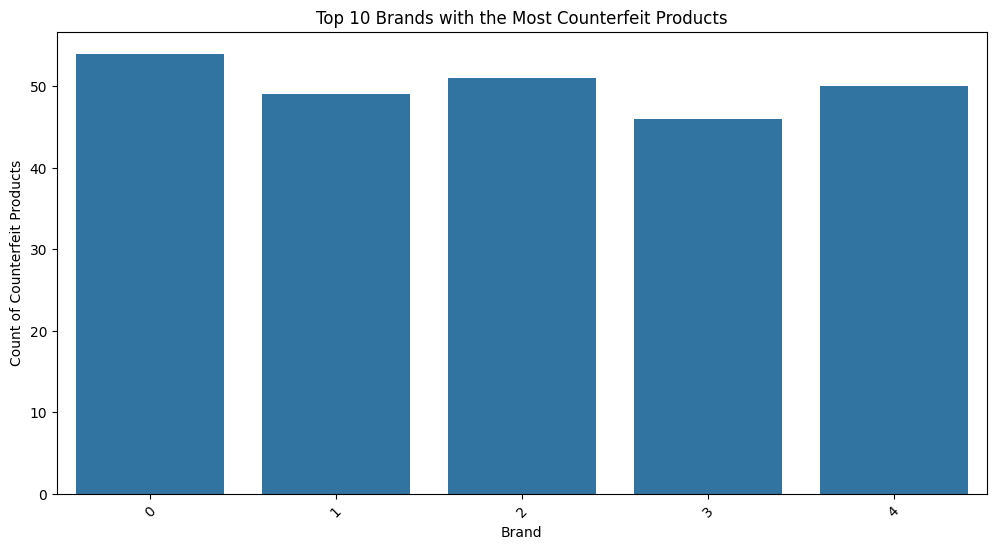


Brand Count Table:
   Brand  Count
0      0    111
1      2    101
2      4     99
3      1     95
4      3     94

Here is the count of counterfeit and genuine products for each category:

          Genuine  Counterfeit
Category                      
0              67           66
1              55           54
2              62           64
3              66           66


In [ ]:
# 2. Bar Plot Showing Which Brand Has the Most Fake Products
plt.figure(figsize=(12, 6))
sns.barplot(x=products['Brand'].value_counts().index[:10], y=products[products['Is_Counterfeit'] == 1]['Brand'].value_counts().values[:10])
plt.xticks(rotation=45)
plt.title("Top 10 Brands with the Most Counterfeit Products")
plt.xlabel("Brand")
plt.ylabel("Count of Counterfeit Products")
plt.show()

# 3. Count of Brands in a Tabular Form
brand_counts = products['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']
print("\nBrand Count Table:")
print(brand_counts)

# 4. Display the Category Count Table After Bar Plot
print("\nHere is the count of counterfeit and genuine products for each category:\n")
print(category_counts)


In [ ]:
# 5. Count of Brands in a Tabular Form
brand_counts = products['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

print("\nBrand Count Table:")
print(brand_counts.to_string(index=False))  # Display without the default index for better readability



Brand Count Table:
 Brand  Count
     0    111
     2    101
     4     99
     1     95
     3     94
